# Preprocess Dataset

In [1]:
from dlcliche.notebook import *
from dlcliche.image import *
from lib_fat2019 import *

conf.DATA = Path('/mnt/dataset/freesound-audio-tagging-2019')
conf.ROOT = Path('/mnt/dataset/fat2019_files')
conf.WORK = Path('/mnt/dataset/work/fat2019')

update_conf(conf)

## CSV_TRN_NOISY split

In [ ]:
## Stage 1: Set CV

Then pretrain model.

test_size = 0.2

df = pd.read_csv(conf.CSV_TRN_NOISY)

# Noisy CV
val_idxs = np.random.choice(df.index, size=int(test_size * len(df)))
trn_idxs = [i for i in df.index if i not in val_idxs]
df['train'] = True
df.loc[val_idxs, 'train'] = False

df.to_csv(conf.CSV_TRN_NOISY_CV, index=False)

## CSV_TRN_NOISY_SINGLE re-assembling and split


In [2]:
set_fastai_random_seed()

df = pd.read_csv(conf.CSV_TRN_NOISY)
for i in df.index:
    df.loc[i, 'label'] = np.random.choice(df.loc[i, 'labels'].split(','))

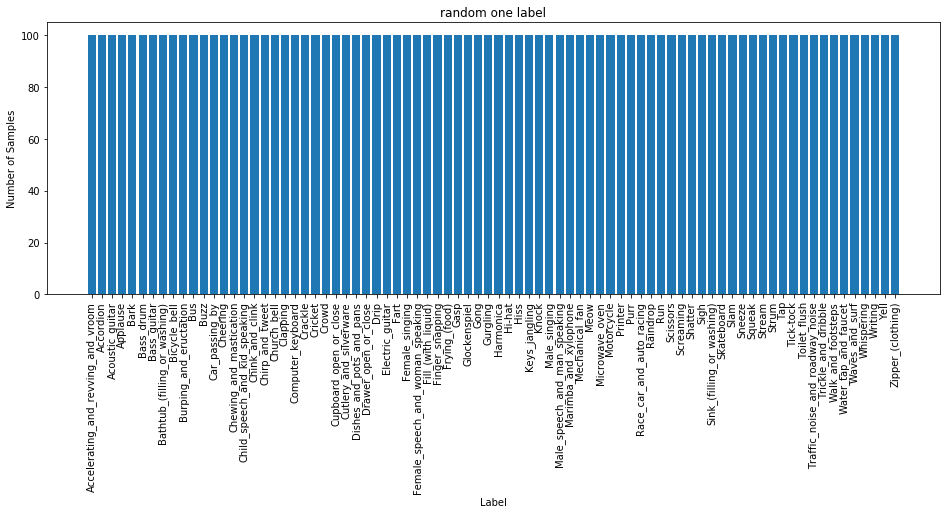

In [3]:
N = 100
classes = get_classes(conf)
dists = get_class_distribution_list([classes.index(l) for l in df.label], len(classes))
n_samples_per_class = N # int(min(dists))

# Select n_samples_per_class indexes for all class
all_cls_idxs = []
for c in classes:
    idxs = np.where(df.label == c)[0]
    np.random.shuffle(idxs)
    all_cls_idxs.append(idxs[:n_samples_per_class])

single_sample_idxs = sorted(flatten_list(all_cls_idxs))
single_df = df.loc[single_sample_idxs]
single_df['org_index'] = single_df.index

visualize_class_balance('random one label', single_df.label)

In [4]:
single_df.columns = ['fname', 'org_labels', 'labels', 'org_index']
single_df.reset_index(drop=True, inplace=True)
single_df.to_csv(conf.CSV_TRN_NOISY_SINGLE, index=False)

### Adding `train` column for pretraining split

In [22]:
VAL_K = 5
single_df = pd.read_csv(conf.CSV_TRN_NOISY_SINGLE)
classes = get_classes(conf)
cls_idxs = [[idx for idx, row in single_df.iterrows() if row.labels == c] for c in classes]

In [50]:
import random
val_idxs = [random.sample(idxs, VAL_K) for idxs in cls_idxs]
print(val_idxs[:3], len(set(flatten_list(val_idxs))))

[[1694, 3732, 1898, 1897, 171], [5225, 5717, 7997, 3540, 4381], [4450, 4017, 44, 5068, 2950]] 400


In [51]:
single_df['train'] = True
single_df.loc[flatten_list(val_idxs), 'train'] = False
print(len(single_df[single_df.train]), len(single_df[~single_df.train]))

7600 400


In [52]:
single_df.to_csv(conf.CSV_TRN_NOISY_SINGLE, index=False)
single_df.columns

Index(['fname', 'org_labels', 'labels', 'org_index', 'train'], dtype='object')

In [16]:
# test
import collections
print([item for item, count in collections.Counter(fl).items() if count > 1])
single_df.loc[[2332, 6200, 5461, 5395, 4850, 1826, 3788]]

[2332, 6200, 5461, 5395, 4850, 1826, 3788]


,fname,org_labels,labels,org_index,train
2332,4a66a999.wav,Accelerating_and_revving_and_vroom,Accelerating_and_revving_and_vroom,5784,False
6200,c5bb5222.wav,Accordion,Accordion,15341,False
5461,ad4eb2eb.wav,Cricket,Cricket,13508,False
5395,ab428d67.wav,Printer,Printer,13352,False
4850,9afc79e1.wav,Sink_(filling_or_washing),Sink_(filling_or_washing),12042,False
1826,3a2082e8.wav,Walk_and_footsteps,Walk_and_footsteps,4547,False
3788,78c6fcac.wav,Waves_and_surf,Waves_and_surf,9393,False


## CSV_TRN_NOISY_BEST50S split

In [3]:
trn_noisy_df = pd.read_csv(conf.CSV_TRN_NOISY)
VAL_K = 3

# Make best50s df
classes = get_classes(conf)

singles_df = trn_noisy_df[~trn_noisy_df.labels.str.contains(',')].copy()
idxes_best50s = np.array([random.choices(singles_df[(singles_df.labels == cls)].index, k=50)
                          for cls in classes]).ravel()
best50s_df = singles_df.loc[idxes_best50s].copy()

cls_idxs = [[idx for idx, row in best50s_df.iterrows() if row.labels == c] for c in classes]
val_idxs = [random.sample(idxs, VAL_K) for idxs in cls_idxs]
print(val_idxs[:3], len(set(flatten_list(val_idxs))))

[[1822, 5371, 17980], [19810, 14202, 8244], [6069, 11339, 9222]] 240


In [4]:
best50s_df['train'] = True
best50s_df.loc[flatten_list(val_idxs), 'train'] = False
print(len(best50s_df[best50s_df.train]), len(best50s_df[~best50s_df.train]))

3693 307


In [ ]:
best50s_df.to_csv(conf.CSV_TRN_NOISY_BEST50S, index=False)

## CSV_TRN_CURATED split

In [ ]:
classes = get_classes(conf)
escaped_classes = [re.escape(c) for c in classes]

def visu(df, comment=''):
    visualize_class_balance(comment, flatten_list(df.labels.str.split(',')))

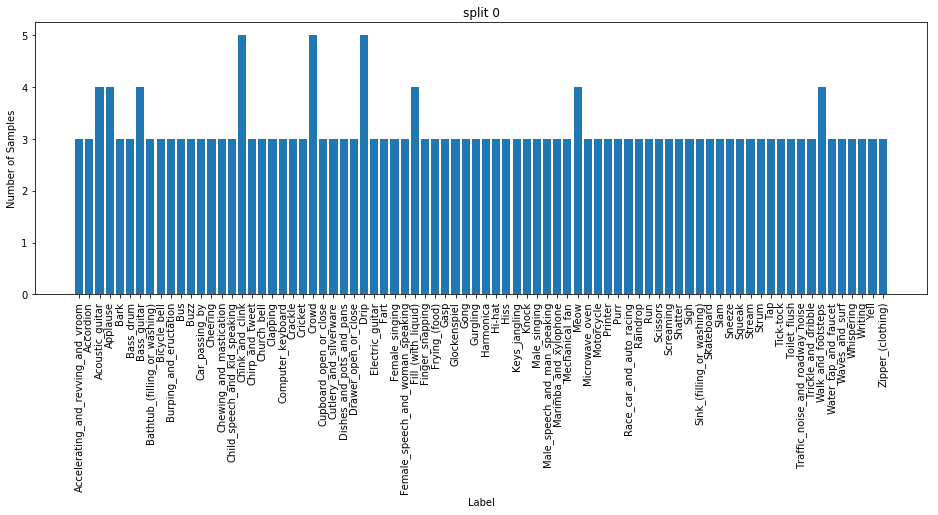

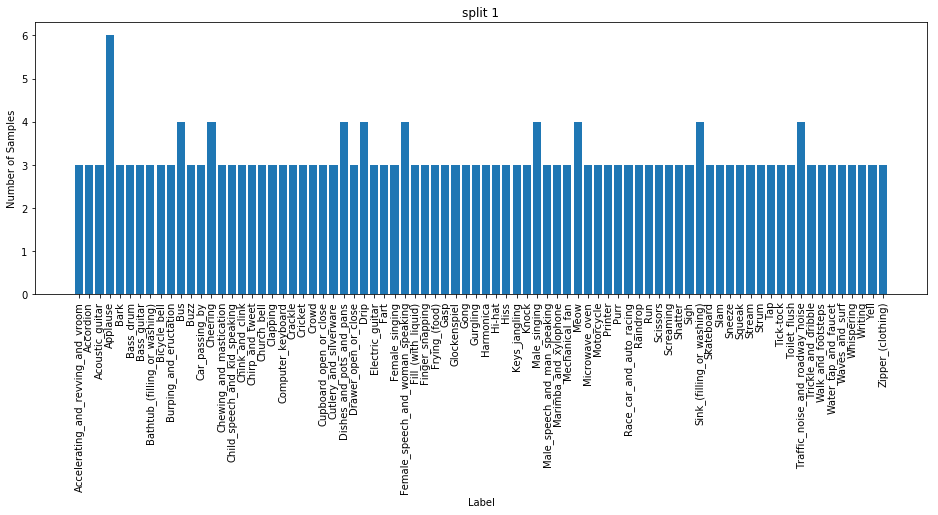

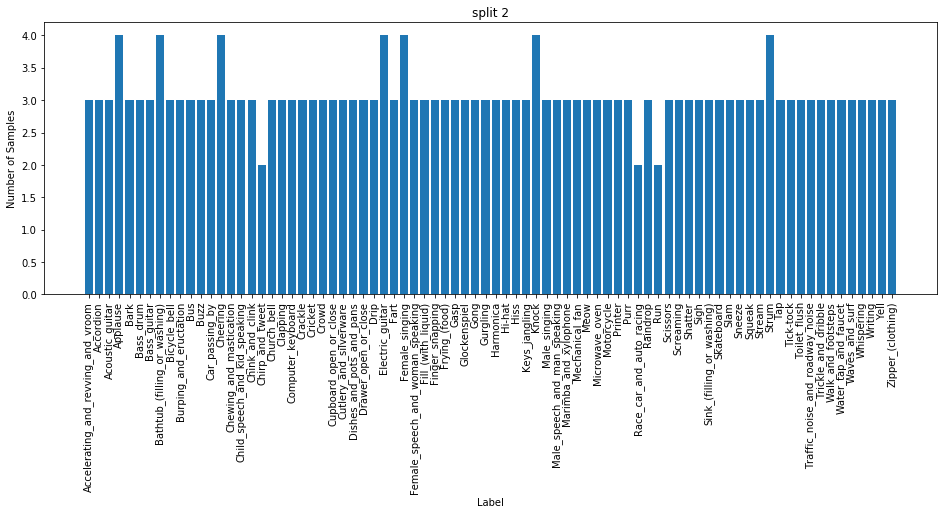

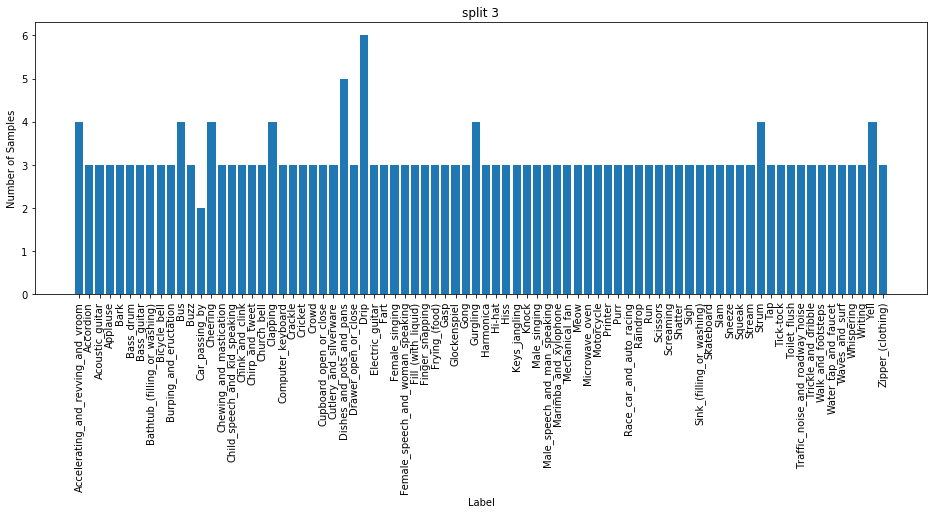

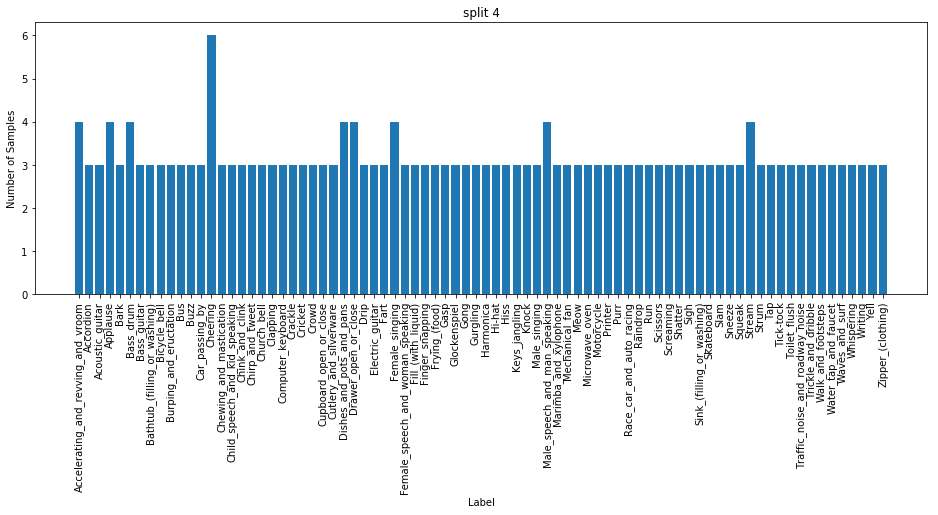

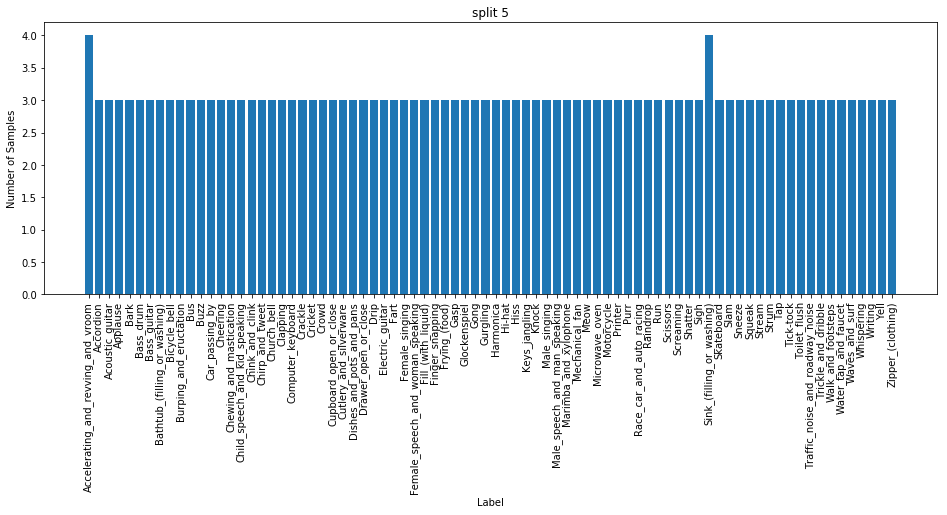

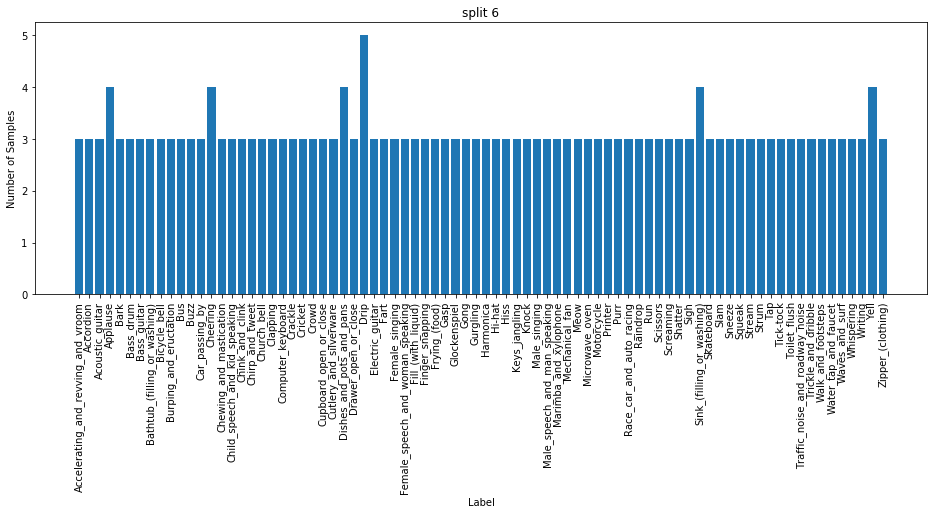

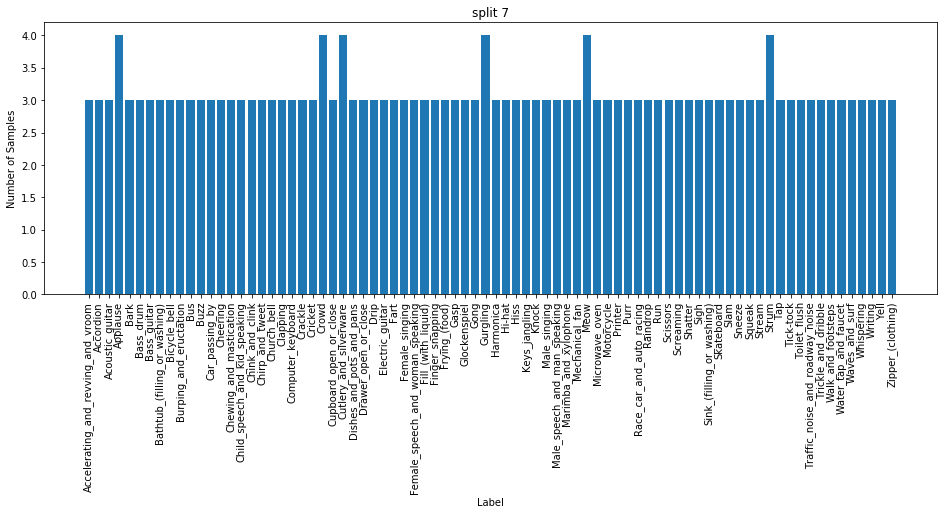

In [2]:
set_fastai_random_seed()

# 3 samples, all class evenly
df = pd.read_csv(conf.CSV_TRN_CURATED)
add_one_hot(df, classes)
sample_one_hots = df[classes].values

K = 3

def choose_validx(cls_idxs, sample_one_hots, k=K):
    count = np.array([0] * len(classes))
    validxs = []
    # pick from all classes, one by one
    for i in range(k):
        targ = i + 1
        for ci in range(len(classes)):
            if count[ci] >= targ: continue # skip, already too much
            # pick an index
            picked = np.random.choice(cls_idxs[ci])
            cls_idxs[ci].remove(picked)
            # move to validxs only if it's not already there
            if picked in validxs: continue
            validxs.append(picked)
            # count
            count = count + sample_one_hots[picked]
    assert len(set(validxs)) == len(validxs)
    return sorted(validxs)

val_splits = []
n_split = 8
for cur in range(n_split):
    cls_idxs = list_class_indexes(classes, df)
    # remove samples already in other split
    already_pickeds = flatten_list(val_splits)
    cls_idxs = [[i for i in idxs if i not in already_pickeds] for idxs in cls_idxs]
    cur_validxs = choose_validx(cls_idxs, sample_one_hots)
    val_splits.append(cur_validxs)
    visu(df.iloc[cur_validxs], f'split {cur}')

In [3]:
df = pd.read_csv(conf.CSV_TRN_CURATED)
df['valid'] = -1
for i, s in enumerate([5, 7, 2]):
    df.loc[val_splits[s], 'valid'] = i

# test
for i, s in enumerate([5, 7, 2]):
    assert len(df[df.valid == i]) == len(val_splits[s]), f'{s} {len(df[df.valid == i])} != {len(val_splits[s])}'

df

,fname,labels,valid
0,0006ae4e.wav,Bark,-1
1,0019ef41.wav,Raindrop,-1
2,001ec0ad.wav,Finger_snapping,0
3,0026c7cb.wav,Run,-1
4,0026f116.wav,Finger_snapping,-1
5,003be5db.wav,Whispering,-1
6,0041de6b.wav,"Acoustic_guitar,Strum",-1
7,004ca909.wav,Hi-hat,-1
8,00713ec2.wav,Bass_drum,-1
9,0073825a.wav,"Crowd,Cheering",-1


In [5]:
df.to_csv(conf.CSV_TRN_CV, index=False)